In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data_utils


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

import copy
import numpy as np
import pandas as pd


## Loading the trained model

Since pickle can't save the model class, and we got an error when trying to load the model class. Therefore, we have to redefine the CNNNet model here, then load its trained weights to it.

In [33]:
class CNNNet(nn.Module):
    def __init__(self, n_classes) -> None:
        super(CNNNet, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=75, kernel_size=3, stride=1)
        self.batchnorm1 = nn.BatchNorm2d(75)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=75, out_channels=50, kernel_size=3, stride=1)
        self.batchnorm2 = nn.BatchNorm2d(50)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=50, out_channels=25, kernel_size=3, stride=1)
        self.batchnorm3 = nn.BatchNorm2d(25)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride=1)

        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.3)

        self.fc1 = nn.Linear(2*2*25, 512)
        self.fc2 = nn.Linear(512, self.n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # print('input x', x.size())
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)
        # print('after block 1', x.size())

        x = F.relu(self.conv2(x))
        x = self.dropout1(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)
        # print('after block 2', x.size())

        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool3(x)
        print('after block 3', x.size())

        # x = torch.flatten(x, -1)
        x = x.view(-1,2*2*25 )
        # print('after flattening', x.size())

        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return self.softmax(x)


model= CNNNet(n_classes = 24)


In [34]:
model_checkpoint = r'C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\COURSES\CSCE 5218\Project\Computer-Vision-Project\Computer-Vision-Project\reproduced-submission\asl_cnn_aug.pth'
model = torch.load(model_checkpoint)
model.eval()
print(model)

CNNNet(
  (conv1): Conv2d(1, 75, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(75, 50, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=100, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=24, bias=True)
  (softmax): Softmax(dim=1)
)


## Preparing an image for the Model to predict

### Showing the image

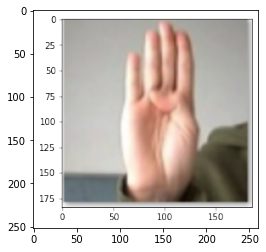

In [28]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

b_img_p = r'C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\COURSES\CSCE 5218\Project\Computer-Vision-Project\Computer-Vision-Project\data\b.png' 
show_image(b_img_p)

### Scaling the image

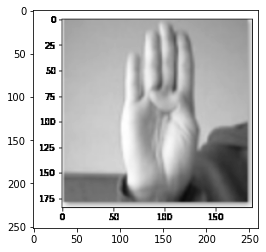

In [29]:
from PIL import Image
def load_and_scale_image(image_path):
    # image = mpimg.imread(image_path)
    image = Image.open(image_path)
    transform = transforms.Grayscale()
    img = transform(image)
    plt.imshow(img, cmap='gray')

load_and_scale_image(b_img_p)


### Preparing the image for prediction

In [30]:
image = Image.open(b_img_p)
transform = transforms.Compose([transforms.Resize([28, 28]),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
img = transform(image)
img = img.reshape(-1,1,28,28) 
img

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -0.2784, -0.2392, -0.3333],
          [-1.0000, -1.0000, -1.0000,  ...,  0.0902,  0.1608,  0.1529],
          [-1.0000, -1.0000, -1.0000,  ...,  0.2078,  0.2471,  0.2235],
          ...,
          [-1.0000, -1.0000, -1.0000,  ...,  0.2941,  0.3020,  0.1294],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -0.2784, -0.2392, -0.3333],
          [-1.0000, -1.0000, -1.0000,  ...,  0.0824,  0.1608,  0.1529],
          [-1.0000, -1.0000, -1.0000,  ...,  0.2000,  0.2471,  0.2235],
          ...,
          [-1.0000, -1.0000, -1.0000,  ...,  0.2941,  0.3020,  0.1294],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -0.3647, -0.2392, -0.3333],
          [-1.0000, -1.000

## Making prediction

In [35]:
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"

In [36]:
prediction = model(img)
_, pred_label = torch.max(prediction.data, 1)
print('predicted label: ', alphabet[pred_label[0]])

after block 3 torch.Size([4, 25, 2, 2])
predicted label:  w


C:\Users\huyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [41]:
np.argmax(prediction.data)

tensor(21)

# Putting together


after block 3 torch.Size([4, 25, 2, 2])


C:\Users\huyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


(21, 'w')

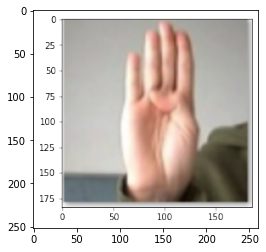

In [51]:
def predict(img_path):
    show_image(img_path)
    alphabet = "abcdefghiklmnopqrstuvwxy"
    image = Image.open(img_path)
    transform = transforms.Compose([transforms.Resize([28, 28]),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])
    img = transform(image)
    img = img.reshape(-1,1,28,28) 
    prediction = model(img)
    pred_label = np.argmax(prediction.data)
    
    return int(pred_label), alphabet[pred_label]

predict(b_img_p)


In [48]:
predict(r'C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\COURSES\CSCE 5218\Project\Computer-Vision-Project\Computer-Vision-Project\data\b.png')

after block 3 torch.Size([4, 25, 2, 2])


C:\Users\huyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


(21, 'w')